Autor: Gustavo Vilela Mitraud <br>
Universidade Presbiteriana Mackenzie

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

df_steam = pd.read_csv("archive\steam.csv")
df_steam

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


Será dado um ID para cada valor em string em cada categoria. <br>
Por exemplo, Valve será igual a 1, Gearbox Software será igual a 2 e assim por diante

In [3]:
def create_ids(lst):
    lst_set = set()
    lst_ids = dict()

    for name in lst:
        if name not in lst_set:
            lst_set.add(name)
    
    for i, name in enumerate(lst_set):
        lst_ids[i] = name

    return lst_ids

dev_lookup = create_ids(df_steam["developer"])
publisher_lookup = create_ids(df_steam["publisher"])


Usando o IF-IDF para achar a similaridade entre os valores das categories "platforms" e "steamspy_tags

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
tf_idf_vectorizer = TfidfVectorizer()
def similarity(text_lst):
    tf_idf_transform = tf_idf_vectorizer.fit_transform(text_lst)
    return cosine_similarity(tf_idf_transform)

cos_sim_platforms = similarity(df_steam["platforms"])
cos_sim_tags = similarity(df_steam["steamspy_tags"])
    
    

Criando o dataframe que sera usado para a recomendação

In [5]:
def transform_to_id(dict_of_ids, lst):
    list_of_ids = []
    keys = list(dict_of_ids.keys())
    values = list(dict_of_ids.values())
    for name in lst:
        list_of_ids.append(keys[values.index(name)])
    
    return list_of_ids

dev_ids = transform_to_id(dev_lookup, df_steam["developer"])
publisher_ids = transform_to_id(publisher_lookup, df_steam["publisher"])

data_dict = {"appid": df_steam["appid"], "dev_ids": dev_ids, "publisher_ids": publisher_ids, "platforms_sim": list(cos_sim_platforms[0]), "tags_sim": list(cos_sim_tags[0])}

data_df = pd.DataFrame(data_dict)
data_df

,appid,dev_ids,publisher_ids,platforms_sim,tags_sim
0,10,7690,6413,1.000000,1.000000
1,20,7690,6413,1.000000,1.000000
2,30,7690,6413,1.000000,0.537860
3,40,7690,6413,1.000000,1.000000
4,50,10159,6413,1.000000,0.420275
...,...,...,...,...,...
27070,1065230,1485,1244,0.278753,0.000000
27071,1065570,10835,13150,0.278753,0.161619
27072,1065650,10934,9140,0.278753,0.163285
27073,1066700,1104,11876,0.676292,0.000000


Aplicado o algoritmo K-means no dataframe

In [6]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(2)

reshaped_data = pca.fit_transform(data_df)
reshaped_data.shape

(27075, 2)

In [17]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=10)
clusters = k_means.fit_predict(reshaped_data)
clusters

c:\Users\gus_v\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([3, 3, 3, ..., 5, 5, 5])

<function matplotlib.pyplot.show(close=None, block=None)>

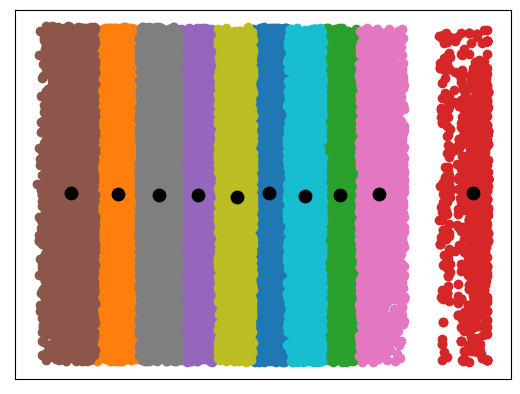

In [24]:
centroids = k_means.cluster_centers_
unique_clusters = np.unique(clusters)
for i in unique_clusters:
    plt.scatter(reshaped_data[clusters == i, 0], reshaped_data[clusters == i, 1], label = i)
plt.scatter(centroids[:,0], centroids[:,1], s = 80, color = "k")
plt.yticks(())
plt.xticks(())
plt.show

Agora vamos testar o modelo

In [19]:
lookup_recomendation = {"game_name": [x.lower() for x in df_steam["name"]], "cluster": clusters}
lookup_recomendation = pd.DataFrame(lookup_recomendation)
lookup_recomendation

,game_name,cluster
0,counter-strike,3
1,team fortress classic,3
2,day of defeat,3
3,deathmatch classic,3
4,half-life: opposing force,3
...,...,...
27070,room of pandora,5
27071,cyber gun,5
27072,super star blast,5
27073,new yankee 7: deer hunters,5


In [23]:
import random

def get_recomendation(game):
    cluster_to_recomend = int(lookup_recomendation.loc[lookup_recomendation["game_name"]==game]["cluster"])
    list_of_games = list(lookup_recomendation.loc[lookup_recomendation["cluster"]==cluster_to_recomend]["game_name"])
    return random.sample(list_of_games, 5)

get_recomendation("Counter-Strike".lower())

['tropico 3',
 'crazy machines 2',
 'tank universal',
 'nancy drew®: the haunted carousel',
 'star wars™ jedi knight: dark forces ii']